In [ ]:
#!pip install sqlalchemy
import json
import os
import itertools
from datetime import datetime
import math
from sqlalchemy import create_engine

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.backend import clear_session
from keras import backend as K

In [ ]:
import matplotlib.pyplot as plt
#!pip install pickle5
import pickle

In [ ]:
#!pip install colorcet
import pandas as pd
from pandas.api.types import CategoricalDtype 
import numpy as np
import colorcet as cc
from numpy import linspace
from scipy.stats.kde import gaussian_kde

In [ ]:
#leggo i dataframe dal disco
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = 'drive/MyDrive/Colab Notebooks/PHP4/Remaining_Life_Estimation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_pickle(DATA_PATH + '/train_df.pkl')
test_df = pd.read_pickle(DATA_PATH + '/test_df.pkl')
train_df_y = pd.read_pickle(DATA_PATH + '/train_df_y.pkl')
test_df_y = pd.read_pickle(DATA_PATH + '/test_df_y.pkl')

In [ ]:
#!ls 'drive/MyDrive/Colab Notebooks'

In [ ]:
num_steps = 50
batch_size = 1
num_features_x = 24
num_features_y = 3

n_rows = train_df.shape[0] % (num_steps * batch_size)
n_rows

31

In [ ]:
train_df.drop(train_df.tail(n_rows).index, inplace = True)
train_df_y.drop(train_df_y.tail(n_rows).index, inplace = True)
n_rows = test_df.shape[0] % (num_steps * batch_size)
test_df.drop(test_df.tail(n_rows).index, inplace = True)
test_df_y.drop(test_df_y.tail(n_rows).index, inplace = True)
train_df.shape[0]

20600

In [ ]:
#train_df.isnull().values.any()
#pd.set_option("display.max_columns", None)
#train_df[train_df.isnull().any(axis=1)]
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
#pd.reset_option("display.max_columns")

In [ ]:
x_train = train_df.drop(['id', 'cycle'],axis=1).to_numpy()
x_test = test_df.drop(['id', 'cycle'],axis=1).to_numpy()
y_train = train_df_y.drop(['id', 'cycle'],axis=1).to_numpy()
y_test = test_df_y.drop(['id', 'cycle'],axis=1).to_numpy()

In [ ]:
x_train

array([[-0.31597968, -1.3729532 ,  0.        , ...,  0.        ,
         1.34849274,  1.19442705],
       [ 0.87272193, -1.03172035,  0.        , ...,  0.        ,
         1.01652793,  1.23692196],
       [-1.96187421,  1.01567674,  0.        , ...,  0.        ,
         0.73989059,  0.50342281],
       ...,
       [ 0.82700264, -1.3729532 ,  0.        , ...,  0.        ,
        -1.14124336, -0.57465465],
       [-1.23036553, -0.69048751,  0.        , ...,  0.        ,
        -1.14124336, -0.25132379],
       [-0.86461119, -1.03172035,  0.        , ...,  0.        ,
        -0.58796867, -0.67996813]])

In [ ]:
x_train_shaped = np.reshape(x_train, newshape=(-1, num_steps, num_features_x))
x_test_shaped = np.reshape(x_test, newshape=(-1, num_steps, num_features_x))
y_train_shaped = np.reshape(y_train, newshape=(-1, num_steps, num_features_y))
y_test_shaped = np.reshape(y_test, newshape=(-1, num_steps, num_features_y))

In [ ]:
print(x_train_shaped.shape)
print(y_train_shaped.shape)
print(x_test_shaped.shape)
print(y_test_shaped.shape)

(412, 50, 24)
(412, 50, 3)
(261, 50, 24)
(261, 50, 3)


In [ ]:
x_train_final = np.asarray(x_train_shaped).astype('float32')
y_train_final = np.asarray(y_train_shaped).astype('float32')
x_test_final = np.asarray(x_test_shaped).astype('float32')
y_test_final = np.asarray(y_test_shaped).astype('float32')

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
weights = np.array([0.5,5,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
loss = weighted_categorical_crossentropy(weights)

In [ ]:
#model
model = Sequential()
#input
model.add(LSTM(units=50, return_sequences=True, activation='tanh', batch_size=batch_size, stateful=True, input_shape = (x_train_final.shape[1], x_train_final.shape[2])))
model.add(Dropout(0.2))
#hidden layer 1
model.add(LSTM(units=60, return_sequences=True, activation='tanh', stateful=True))
model.add(Dropout(0.2))
#hidden layer 2
model.add(LSTM(units=60, return_sequences=True, activation='tanh', stateful=True))
model.add(Dropout(0.2))
#output
model.add(Dense(units=3,activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
#summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 50, 50)               15000     
_________________________________________________________________
dropout (Dropout)            (1, 50, 50)               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 50, 60)               26640     
_________________________________________________________________
dropout_1 (Dropout)          (1, 50, 60)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 50, 60)               29040     
_________________________________________________________________
dropout_2 (Dropout)          (1, 50, 60)               0         
_________________________________________________________________
dense (Dense)                (1, 50, 3)                1

In [ ]:
clear_session()
history = model.fit(x_train_final, y_train_final, batch_size=batch_size, shuffle=False, epochs=50)

Epoch 1/50
412/412 [==============================] - 12s 27ms/step - loss: 0.1907 - accuracy: 0.9650
Epoch 2/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0733 - accuracy: 0.9812
Epoch 3/50
412/412 [==============================] - 11s 28ms/step - loss: 0.0442 - accuracy: 0.9897
Epoch 4/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0440 - accuracy: 0.9901
Epoch 5/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0432 - accuracy: 0.9880
Epoch 6/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0383 - accuracy: 0.9907
Epoch 7/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0425 - accuracy: 0.9890
Epoch 8/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0387 - accuracy: 0.9930
Epoch 9/50
412/412 [==============================] - 11s 27ms/step - loss: 0.0723 - accuracy: 0.9792
Epoch 10/50
412/412 [==============================] - 11s 27ms/step - loss: 0.066

In [ ]:
#model.save(DATA_PATH + '/model.keras')
#pickle.dump(history, open('history.pkl','wb'))

In [ ]:
#model = load_model(DATA_PATH + '/model.keras')
#history = pickle.load(open('history.pkl','rb'))

In [ ]:
model.evaluate(x_test_final, y_test_final, batch_size=batch_size, verbose=2)

261/261 - 2s - loss: 0.5081 - accuracy: 0.9526


[0.5080830454826355, 0.9526436924934387]

In [ ]:
#pd.DataFrame(np.reshape(model.predict(x_test_final, batch_size=batch_size), newshape=(-1, num_features_y))).to_csv(DATA_PATH + "/check_accuracy_predict.csv")
#pd.DataFrame(np.reshape(y_test_final, newshape=(-1, num_features_y))).to_csv(DATA_PATH + "/check_accuracy_test_real.csv")

In [ ]:
#model.predict(x_test_final, batch_size=batch_size)

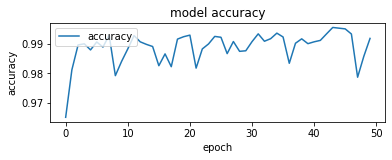

In [ ]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

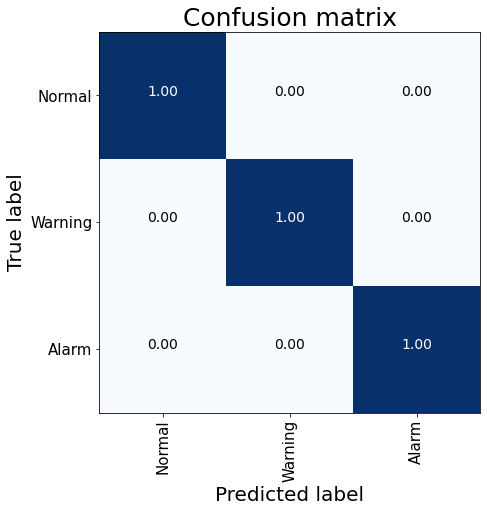

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(np.reshape(y_train_final, newshape=(-1, num_features_y)), axis=1), np.argmax(np.reshape(model.predict(x_train_final, batch_size=batch_size), newshape=(-1, num_features_y)),axis=1))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['Normal','Warning','Alarm'], title="Confusion matrix")
plt.show()

In [ ]:
pd.DataFrame(np.argmax(np.reshape(model.predict(x_test_final, batch_size=batch_size), newshape=(-1, num_features_y)),axis=1)).to_csv(DATA_PATH + "/check_accuracy_predict_argmax.csv")
pd.DataFrame(np.argmax(np.reshape(y_test_final, newshape=(-1, num_features_y)), axis=1)).to_csv(DATA_PATH + "/check_accuracy_test_real_argmax.csv")

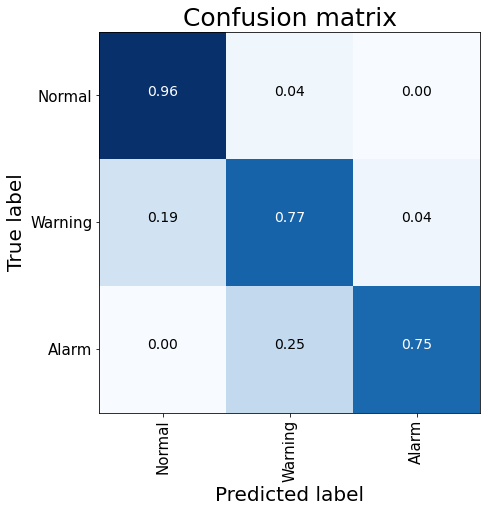

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(np.reshape(y_test_final, newshape=(-1, num_features_y)), axis=1), np.argmax(np.reshape(model.predict(x_test_final, batch_size=batch_size), newshape=(-1, num_features_y)),axis=1))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['Normal','Warning','Alarm'], title="Confusion matrix")
plt.show()